# Generative Adversarial Network (GAN)

In [48]:
import os
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import ImageFolder
import torchvision.transforms as trans
from torchvision.utils import save_image
from torchvision.utils import make_grid

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

# Data directory

In [49]:
data_dir = 'dataset/'
print(os.listdir(data_dir)[:3])

['9814.jpg', '9769.jpg', '927.jpg']


# Defining training data and loader

In [50]:
image_size = 64
batch_size = 128
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)
train_data = ImageFolder(
    data_dir,
    transform = trans.Compose(
        [
         trans.Resize(image_size),
         trans.RandomRotation(5),
         trans.RandomHorizontalFlip(0.5),
         trans.CenterCrop(image_size),
         trans.ToTensor(),
         trans.Normalize(mean = mean, std = std)
        ]
    )
)

train_loader = DataLoader(
    train_data,
    batch_size,
    shuffle = True,
    num_workers = 2,
    pin_memory = True
)

# Display images

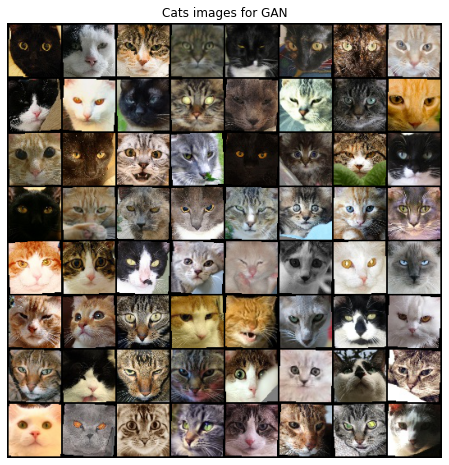

In [51]:
def denorm(img_tensors):
    return img_tensors * std[0] + mean[0]

def show_images(images, nmax=8):
    fig, plot = plt.subplots(figsize=(8, 8))
    plt.title("Cats images for GAN")
    plt.axis("off")
    plot.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

show_batch(train_loader)

# Select device

In [52]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(device)

cuda


# Discriminator description

In [61]:
discriminator = nn.Sequential(
    
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid()
)

discriminator = discriminator.to(device)

# Generator description

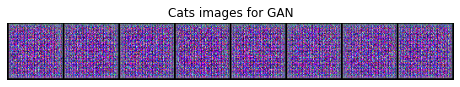

In [62]:
generator = nn.Sequential(

    nn.ConvTranspose2d(128, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

generator = generator.to(device)

# Train discriminator

In [63]:
def train_disc(real_images, disc):
  disc.zero_grad()

  real_prediction = discriminator(real_images)
  real_target = torch.ones(real_images.size(0), 1, device = device)
  real_loss = F.binary_cross_entropy(real_prediction, real_target)
  real_score = torch.mean(real_prediction).item()

  latent = torch.randn(batch_size, 128, 1, 1, device=device)
  fake_images = generator(latent)

  fake_target = torch.zeros(fake_images.size(0), 1, device = device)
  fake_prediction = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_prediction, fake_target)
  fake_score = torch.mean(fake_prediction).item()

  loss = real_loss + fake_loss
  loss.backward()
  disc.step()
  return loss.item(), real_score, fake_score

# Train generator

In [64]:
def train_gen(gen):
  gen.zero_grad()

  latent = torch.randn(batch_size, 128, 1, 1, device=device)
  fake_images = generator(latent)

  prediction = discriminator(fake_images)
  target = torch.ones(batch_size, 1, device = device)
  loss = F.binary_cross_entropy(prediction, target)

  loss.backward()
  gen.step()

  return loss.item()

# Save generated images

In [65]:
newfolder = 'generated_images'
os.makedirs(newfolder, exist_ok=True)

def save_generated_images(index, latent_tensors):
  fake_images = generator(latent_tensors)
  fake_file = 'output-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(newfolder, fake_file), nrow = 8)

fixed_latent = torch.randn(64, 128, 1, 1, device=device)
save_generated_images(0, fixed_latent)

# Model definition

In [66]:
def model (epochs, learning_rate, start_index = 1):
  torch.cuda.empty_cache()

  real_scores = []
  fake_scores = []
  loss_gen = []
  loss_disc = []
  print(discriminator.parameters())
  print(generator.parameters())
  genopt = torch.optim.Adam(generator.parameters(), lr = learning_rate, betas = (0.5, 0.999))
  discopt = torch.optim.Adam(discriminator.parameters(), lr = learning_rate, betas = (0.5, 0.999))
  for epoch in range(epochs):
    for real_images, _ in tqdm(train_loader):
      real_images = real_images.to(device)
      discloss, real_score, fake_score = train_disc(real_images, discopt)
      genloss = train_gen(genopt)
    loss_gen.append(genloss)
    loss_disc.append(discloss)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    print("Epoch [{}/{}], genloss: {:.4f}, discloss: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, genloss, discloss, real_score, fake_score))
    
    save_generated_images(epoch+start_index, fixed_latent)
    
  return loss_gen, loss_disc, real_scores, fake_scores

learning_rate = 0.0002
epochs = 50

history = model(epochs, learning_rate)

loss_gen, loss_disc, real_scores, fake_scores = history

<generator object Module.parameters at 0x7f88998d6bd0>
<generator object Module.parameters at 0x7f88998d6bd0>


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [1/60], genloss: 5.9026, discloss: 0.3144, real_score: 0.8664, fake_score: 0.1356


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/60], genloss: 5.8657, discloss: 0.0757, real_score: 0.9724, fake_score: 0.0454


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3/60], genloss: 4.5021, discloss: 0.8034, real_score: 0.9989, fake_score: 0.3958


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4/60], genloss: 2.7029, discloss: 0.5464, real_score: 0.8129, fake_score: 0.2598


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5/60], genloss: 4.5025, discloss: 0.5235, real_score: 0.8672, fake_score: 0.2987


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6/60], genloss: 3.4303, discloss: 0.3716, real_score: 0.8420, fake_score: 0.1615


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7/60], genloss: 5.2571, discloss: 0.1429, real_score: 0.9434, fake_score: 0.0767


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8/60], genloss: 2.4556, discloss: 1.0305, real_score: 0.5620, fake_score: 0.3091


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9/60], genloss: 3.2404, discloss: 0.4677, real_score: 0.7920, fake_score: 0.1950


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [10/60], genloss: 3.8297, discloss: 0.3501, real_score: 0.9103, fake_score: 0.2094


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [11/60], genloss: 7.4236, discloss: 0.8693, real_score: 0.9788, fake_score: 0.5087


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [12/60], genloss: 4.5507, discloss: 0.1624, real_score: 0.9813, fake_score: 0.1288


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [13/60], genloss: 0.3208, discloss: 1.5206, real_score: 0.2286, fake_score: 0.0254


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [14/60], genloss: 4.0661, discloss: 0.1498, real_score: 0.9844, fake_score: 0.1202


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [15/60], genloss: 3.7711, discloss: 0.2323, real_score: 0.8452, fake_score: 0.0526


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [16/60], genloss: 4.6895, discloss: 0.5279, real_score: 0.8020, fake_score: 0.2337


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [17/60], genloss: 4.6097, discloss: 1.2749, real_score: 0.7664, fake_score: 0.5303


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [18/60], genloss: 4.0450, discloss: 3.3125, real_score: 0.0557, fake_score: 0.0012


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [19/60], genloss: 4.3055, discloss: 0.2687, real_score: 0.9686, fake_score: 0.1955


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [20/60], genloss: 1.3240, discloss: 0.7104, real_score: 0.5505, fake_score: 0.0673


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [21/60], genloss: 5.5097, discloss: 5.6450, real_score: 0.0064, fake_score: 0.0002


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [22/60], genloss: 4.5926, discloss: 0.2320, real_score: 0.9540, fake_score: 0.1562


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [23/60], genloss: 4.6602, discloss: 0.2512, real_score: 0.7888, fake_score: 0.0027


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [24/60], genloss: 0.6255, discloss: 1.1439, real_score: 0.3486, fake_score: 0.0437


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [25/60], genloss: 4.6220, discloss: 0.0475, real_score: 0.9613, fake_score: 0.0074


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [26/60], genloss: 4.7213, discloss: 0.2574, real_score: 0.9985, fake_score: 0.2111


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [27/60], genloss: 4.9109, discloss: 0.0196, real_score: 0.9897, fake_score: 0.0092


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [28/60], genloss: 3.5933, discloss: 0.0961, real_score: 0.9798, fake_score: 0.0709


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [29/60], genloss: 3.8262, discloss: 0.0191, real_score: 0.9946, fake_score: 0.0134


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [30/60], genloss: 4.7587, discloss: 0.0171, real_score: 0.9970, fake_score: 0.0140


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [31/60], genloss: 6.3966, discloss: 0.3362, real_score: 0.7377, fake_score: 0.0007


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [32/60], genloss: 3.6751, discloss: 0.1001, real_score: 0.9969, fake_score: 0.0885


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [33/60], genloss: 6.0923, discloss: 0.3570, real_score: 0.9273, fake_score: 0.2302


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [34/60], genloss: 3.6657, discloss: 0.7162, real_score: 0.5410, fake_score: 0.0012


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [35/60], genloss: 3.2267, discloss: 0.2694, real_score: 0.9188, fake_score: 0.1467


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [36/60], genloss: 4.5999, discloss: 0.0099, real_score: 0.9993, fake_score: 0.0091


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [37/60], genloss: 10.4270, discloss: 0.1364, real_score: 0.8866, fake_score: 0.0001


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [38/60], genloss: 3.8279, discloss: 0.3759, real_score: 0.8542, fake_score: 0.1788


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [39/60], genloss: 4.3623, discloss: 0.0497, real_score: 0.9843, fake_score: 0.0327


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [40/60], genloss: 3.7084, discloss: 0.0738, real_score: 0.9769, fake_score: 0.0475


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [41/60], genloss: 3.6633, discloss: 0.2017, real_score: 0.8356, fake_score: 0.0186


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [42/60], genloss: 12.2339, discloss: 1.3207, real_score: 0.9697, fake_score: 0.5671


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [43/60], genloss: 3.5737, discloss: 0.6124, real_score: 0.7482, fake_score: 0.2294


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [44/60], genloss: 1.5920, discloss: 0.2860, real_score: 0.7759, fake_score: 0.0282


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [45/60], genloss: 8.6385, discloss: 0.7643, real_score: 0.9999, fake_score: 0.4229


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [46/60], genloss: 3.4728, discloss: 0.2826, real_score: 0.7910, fake_score: 0.0310


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [47/60], genloss: 2.7249, discloss: 0.4492, real_score: 0.7306, fake_score: 0.0955


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [48/60], genloss: 4.9472, discloss: 0.1102, real_score: 0.9069, fake_score: 0.0028


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [49/60], genloss: 4.9759, discloss: 0.0204, real_score: 0.9975, fake_score: 0.0175


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [50/60], genloss: 5.0826, discloss: 0.1458, real_score: 0.9998, fake_score: 0.1304


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [51/60], genloss: 6.0153, discloss: 0.0104, real_score: 0.9986, fake_score: 0.0088


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [52/60], genloss: 7.2736, discloss: 0.5369, real_score: 0.6646, fake_score: 0.0001


  0%|          | 0/124 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

# Scores graph

In [67]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('iterations')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Real and fake scores');

NameError: ignored

# Losses graph

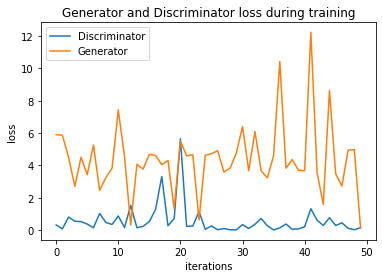

In [70]:
plt.plot(loss_disc, '-')
plt.plot(loss_gen, '-')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Generator and Discriminator loss during training');